# Definitions

In [25]:
import torch

torch.cuda.set_device(1)
device = torch.device("cuda:1")

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import math
sys.path.append("../../packages/")

from utilities import *
from made import *
from global_steps import *

In [27]:
def compute_Pm(J):
    N = J.shape[0]
    dp = torch.zeros(2 * N + 1, dtype=J.dtype, device=J.device)
    dp[N] = 1.0
    m_vector = torch.arange(-N, N + 1, dtype=J.dtype, device=J.device)
    for l in range(N):
        new_dp = torch.zeros_like(dp)
        up = torch.sigmoid(2 * J[l] * m_vector[:-1])
        new_dp[1:] += dp[:-1] * up
        down = 1 - torch.sigmoid(2 * J[l] * m_vector[1:])
        new_dp[:-1] += dp[1:] * down
        dp = new_dp
    return dp

In [28]:
def transition_matrix_global(probMADE, beta, N):
    M = len(probMADE)  # M should be N/2 + 1
    T = np.zeros((M, M), dtype=float)
    m_vals = np.arange(M) * (2.0 / N)  # m_i = 2*i/N, with m_max=1
    
    # Precompute the configuration counts (degeneracies)
    config = np.zeros(M, dtype=float)
    config[0] = comb(N, N//2)
    for i in range(1, M):
        config[i] = 2 * comb(N, (N//2) + i)
    
    for i in range(M):
        m_i = m_vals[i]
        for j in range(M):
            if j != i:
                exponent = 0.5 * beta * N * (m_vals[j]**2 - m_i**2)
                ratio = np.exp(exponent) * (probMADE[i] * config[j]) / (probMADE[j] * config[i])
                alpha = min(1.0, ratio)
                T[i, j] = probMADE[j] * alpha
        T[i, i] = 1.0 - T[i, :].sum()
    return T

# transition matrix for the Markov chain
def transition_matrix_local(N, beta):
    """
    Get the transition matrix for the system in magnetization space.

    Parameters:
    - N (int): The number of spins in the system.
    - beta (float): The inverse temperature (1/kT) of the system.

    Returns:
    - torch.Tensor: A transition matrix of shape ((N/2)+1, (N/2)+1) representing 
                  the probabilities of transitioning between different magnetization states.
    """
    P = torch.zeros((int(N/2)+1, int(N/2)+1))

    for i in range(0, int(N/2)+1):
        m = i*2/N
        if i == 0:
            P[i, 1] = 1
        else: 
            P[i, i-1] = (1+np.abs(m))/2*np.exp(-2*beta*(np.abs(m)-1/N))
            P[i, i] = 1 - (1+np.abs(m))/2*np.exp(-2*beta*(np.abs(m)-1/N)) - (1-np.abs(m))/2
            if i != N/2:
                P[i, i+1] = (1-np.abs(m))/2
    return P

In [29]:
def compute_Pm_abs(N, W):
    Neff = int(N/2)
    probMADE = compute_Pm(torch.tensor(W).cuda())[::2]
    x = probMADE[Neff:]
    x[1:] += torch.flip(probMADE[:Neff], dims=[0])
    probMADE = x
    return probMADE

def get_time_chain(T):
    eigvals = np.abs(np.linalg.eigvals(T))
    second_max_index = np.argsort(eigvals.real)[-2]
    second_eigenvalue = eigvals[second_max_index]
    time = -1/np.log(second_eigenvalue)
    #time = 1/(1-second_eigenvalue)
    return time

def compute_time_MADE(N, beta_target, W, consider_complexity = True):
    probMADE = compute_Pm_abs(N, W)
    T = transition_matrix_global(probMADE, beta_target, N)
    time = get_time_chain(T)
    if consider_complexity:
        return time*N
    else:
        return time

def compute_time_local(N, beta_target):
    T = transition_matrix_local(N, beta_target)
    time = get_time_chain(T)
    return time

def get_matrix_mixed(N, beta_target, W, k):
    probMADE = compute_Pm_abs(N, W)
    Tmade = transition_matrix_global(probMADE, beta_target, N)
    Tlocal = transition_matrix_local(N, beta_target)
    T = Tmade.dot(np.linalg.matrix_power(Tlocal, N*k))
    return T

def compute_time_mixed(N, beta_target, W, k = 1, consider_complexity = True):
    T = get_matrix_mixed(N, beta_target, W, k)
    time = get_time_chain(T)
    if consider_complexity:
        return time*N*(k+1)
    else:
        return time

def get_exact_distribution(N, beta_target):
    T = transition_matrix_local(N, beta_target).T
    eigvals, eigvecs = np.linalg.eig(T)
    max_eigenvalue_index = np.argmax(eigvals.real)
    steady_state_distribution = eigvecs[:, max_eigenvalue_index].real
    steady_state_distribution /= steady_state_distribution.sum()  # Normalize the distribution
    return steady_state_distribution

def compare_times(N, beta_target, W, consider_complexity = True):
    return compute_time_MADE(N, beta_target, W, consider_complexity = consider_complexity), compute_time_local(N, beta_target)

In [30]:
def get_beta(m):
    return np.arctanh(m)/m

In [31]:
def setup_model(W, N = 100):
    model = made(N)
    weights = model.layer.weight.detach()

    # Update each row i of the weight matrix with W[i]
    for i in range(weights.shape[0]):
        weights[i, :] = W[i]

    # Set the upper triangular part of the matrix to 0
    weights = np.tril(weights, -1)  # Keep only the lower triangular part

    # Set the updated weights back to the model
    model.layer.weight.data = torch.tensor(weights)
    model = model.cuda()
    return model

In [32]:
def MLMC_fast(model, data, beta, N,  num_steps = 10, return_correlations = False):
    # NOTA: le correlazioni sono calcolate usando come riferimento il primo campione
    # Non sono mediate sui tempi!
    #Se il primo campione è all'equilibrio, non ci sono problemi
    acc_rates = []
    if return_correlations:
        correlations = [1]
    with torch.no_grad():
        bce = nn.BCELoss(reduction = "none")
        current_config = data.clone()
        for t in range(num_steps):
            new_config = generate_config_fast(model, N, len(data), None)
            
            current_energy = -N*current_config.mean(1)**2/2
            current_probability = torch.sum(bce(model(current_config), (current_config+1)/2), axis = 1)

            new_energy = -N*new_config.mean(1)**2/2
            new_probability = torch.sum(bce(model(new_config), (new_config+1)/2), axis = 1)

            arg_new = -beta*new_energy + new_probability
            arg_current = -beta*current_energy + current_probability

            acceptances = (torch.log(torch.rand(size=(len(data),), device = "cuda")) < (arg_new-arg_current)).int()
            current_config = torch.einsum("i, ij->ij",(1-acceptances),current_config) + torch.einsum("i, ij->ij",acceptances, new_config)
            torch.cuda.empty_cache()
            acc_rates.append(torch.sum(acceptances)/len(data))
            if return_correlations:
                correlations.append(float(torch.mean(data*current_config) - torch.mean(data)*torch.mean(current_config)))
    if return_correlations:
        return current_config, acc_rates, correlations
    else:
        return current_config, acc_rates

def monte_carlo_update_CW(pop, N, beta):
    """Monte Carlo update model using a checkerboard pattern."""
    population = pop.clone()
    pop_size, N = population.shape
    # Define "even" and "odd" indices for a checkerboard update

    # Update spins in two passes (checkerboard pattern)
    random_indices = torch.randint(0, N, (pop_size,))
    magnetizations = population.mean(1)
    sigmas = population[torch.arange(pop_size), random_indices]
    
    # Compute energy difference for each single-spin flip
    delta_E = -2*(1/N - sigmas*magnetizations)
    # Metropolis acceptance criterion for each spin
    acceptance_prob = torch.exp(-beta * delta_E)
    random_vals = torch.rand(pop_size, device=population.device)
    accept = (delta_E < 0) | (random_vals < acceptance_prob)
    
    # Apply accepted flips only for accepted positions
    population[torch.arange(pop_size), random_indices] = torch.where(accept, -sigmas, sigmas)
    return population

# Check

In [33]:
from scipy.special import comb

In [34]:
beta = 1
N = 20

W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta

probMADE = compute_Pm_abs(N, W)

In [35]:
mtarget = 0.4
beta_target = get_beta(mtarget)
nmax = int((1+mtarget)*N/4)

P = get_matrix_mixed(N, beta_target, W, k=1)[:nmax, :nmax]
P = torch.eye(P.shape[0])-P
P_inv = torch.linalg.inv(P)
result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

print(result[0])

tensor(3.8987, dtype=torch.float64)


In [36]:
model = setup_model(W, N=N)

In [47]:
def montecarlo_alternated_abs(N, beta, target_M, model, pop_size = 10000, k = 1):
    # Population of spins, randomly initialized to -1 or 1
    pop = torch.cat([torch.ones((pop_size, N//2)), -torch.ones((pop_size, N//2))], dim=1).cuda()
    # Apply random permutation to each row
    pop = torch.stack([row[torch.randperm(row.size(0))] for row in pop])
    over = False

    # Array to track the time (iteration count) at which each population member reaches the target magnetization
    time_to_target = torch.full((pop_size,), float('inf'), device="cuda")  # Initialized to infinity (not reached yet)

    # Flag to indicate whether each population member has reached the target
    reached_target = torch.zeros(pop_size, dtype=torch.bool, device="cuda")

    magnetizations = pop.sum(1)  
        
    # Check which members have reached the target magnetization (absolute value comparison)
    newly_reached = (torch.abs(magnetizations) >= target_M) & ~reached_target
    
    # Update the time for newly reached members (only for the first time they reach the target)
    time_to_target[newly_reached] = 0
    # Mark members as having reached the target
    reached_target |= newly_reached

    # Loop to update the population using the Monte Carlo method
    for global_step in range(1, 1000):  # Maximum number of iterations
        #pop, _ = MLMC_fast(model, pop, beta, N,  num_steps = 1)
        # Calculate magnetization for each population member
        #magnetizations = pop.sum(1)  
        
        # Check which members have reached the target magnetization (absolute value comparison)
        #newly_reached = (torch.abs(magnetizations) >= target_M) & ~reached_target
        
        # Update the time for newly reached members (only for the first time they reach the target)
        #time_to_target[newly_reached] = N+N+global_step*(N+N*k)
        
        # Mark members as having reached the target
        #reached_target |= newly_reached
        
        # Break if all members of the population have reached the target
        #if reached_target.all():
        #    print("All population members have reached the target magnetization.")
        #    over = True
        #    break
        #
        # Perform a Monte Carlo update for the entire population
        for i in range(k):
            pop = monte_carlo_update_CW(pop, N, beta)  
        pop, _ = MLMC_fast(model, pop, beta, N,  num_steps = 1)
        # Calculate magnetization for each population member
        magnetizations = pop.sum(1)  
        
        # Check which members have reached the target magnetization (absolute value comparison)
        newly_reached = (torch.abs(magnetizations) >= target_M) & ~reached_target
        
        # Update the time for newly reached members (only for the first time they reach the target)
        time_to_target[newly_reached] = global_step
        
        # Mark members as having reached the target
        reached_target |= newly_reached
        
        # Break if all members of the population have reached the target
        if reached_target.all():
            print("All population members have reached the target magnetization.")
            over = True
            break
        if over:
            break

    # Print or save the times to target
    #print("Time to target for each population member:", time_to_target)
    return time_to_target

In [ ]:
beta = 1
N = 700

W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta

model = setup_model(W, N=N)

numeric_results = []
mtarget = 0.2341322682996002
beta_target = 1.0188982236504613

result1 = 2*montecarlo_alternated_abs(N, beta_target, int(mtarget*N), model, pop_size = 10000, k = N*1).mean()
result2 = montecarlo_alternated_abs(N, beta_target, int(mtarget*N), model, pop_size = 10000, k = 0).mean()
print(beta_target, result1, result2, result1/result2)


All population members have reached the target magnetization.
All population members have reached the target magnetization.
1.0188982236504613 tensor(6.3942, device='cuda:1') tensor(3.4850, device='cuda:1') tensor(1.8348, device='cuda:1')


In [41]:
R = np.loadtxt("R_N350.txt")

/home/delbono/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


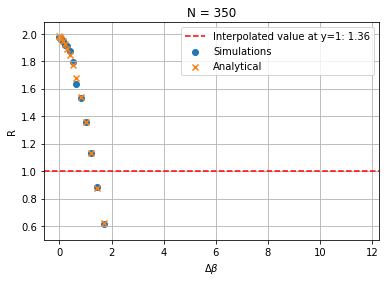

In [54]:
from scipy.interpolate import interp1d

numeric_results = torch.tensor(numeric_results)
plt.scatter((numeric_results[:,0]-1)*np.sqrt(350), numeric_results[:,-1], label = "Simulations")
plt.scatter((R[:,0]-1)*np.sqrt(350), R[:,-1], marker = "x", label = "Analytical")
#plt.xlim(0, 0.1)
# Interpolate the numeric results to find the value at which the curve is 1
interp_func = interp1d((numeric_results[:,0]-1)*np.sqrt(350), numeric_results[:,-1], kind='linear', fill_value="extrapolate")
x_val = interp_func(1)

plt.axhline(y=1, color='r', linestyle='--', label=f'Interpolated value at y=1: {x_val:.2f}')
plt.ylim(0.5)
plt.xlabel(r'$\Delta \beta$')
plt.ylabel('R')
plt.title('N = 350')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
def get_transition_matrix_absm(N, beta):
    """
    Get the transition matrix for the system in magnetization space.

    Parameters:
    - N (int): The number of spins in the system.
    - beta (float): The inverse temperature (1/kT) of the system.

    Returns:
    - torch.Tensor: A transition matrix of shape ((N/2)+1, (N/2)+1) representing 
                  the probabilities of transitioning between different magnetization states.
    """
    P = torch.zeros((int(N/2)+1, int(N/2)+1))

    for i in range(0, int(N/2)+1):
        m = i*2/N
        if i == 0:
            P[i, 1] = 1
        else: 
            P[i, i-1] = (1+np.abs(m))/2*np.exp(-2*beta*(np.abs(m)-1/N))
            P[i, i] = 1 - (1+np.abs(m))/2*np.exp(-2*beta*(np.abs(m)-1/N)) - (1-np.abs(m))/2
            if i != N/2:
                P[i, i+1] = (1-np.abs(m))/2
    return P

In [40]:
beta_target = get_beta(mtarget)
nmax = int((mtarget)*N/2)
k = N*1
P = get_transition_matrix_absm(N, beta_target)
P = torch.matrix_power(P, k)
P = P[:nmax, :nmax]
#P = torch.cat((P[:nmax], P[nmax+1:]))
#P = torch.cat((P[:, :nmax], P[:, nmax+1:]), dim=1)
P = torch.eye(P.shape[0])-P
P_inv = torch.linalg.inv(P)
result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

print(result[0])

tensor(7.3528)


In [32]:
mtarget = 0.74
beta_target = get_beta(mtarget)
nmax = int((mtarget)*N/2)

P = get_matrix_mixed(N, beta_target, W, k=1)[:nmax, :nmax]
P = torch.eye(P.shape[0])-P
P_inv = torch.linalg.inv(P)
result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

print(2*result[0])

tensor(18.5599, dtype=torch.float64)


In [79]:
mtarget = 0.4
nmax = int((mtarget)*N/2)
print(nmax)

4


In [80]:
int(mtarget*N)

8